# Machine Learning Engineer Nanodegree
## Capstone
## Project: Air pressure system failures in Scania trucks

Hajime Kawata  
February 26st, 2019

Predict failure of heavy duty trucks out of sensors data

### Domain Background

Reducing the failure rate of trucks in logictics is an important issue for improving profitability and customer satisfaction in logistics business.
Until now, logistics companies rely on regular maintenance to prevent the occurrence of failures.
However, since the utilization rate of trucks exceeds the days what has been assumed to be covered by periodic maintenance, the percentage of post-maintenance caused by failures increasing, which has been a problem for some time.

For this reason, it is strongly required that inspection and maintenance work be performed before regular failure, by appropriately detecting signs of failure during regular maintenance
In order to properly capture signs of failure, it has been considered to use data collected from sensors installed in trucks, bu sensor data is gathered in milliseconds at longest, and collection targets are also diverse.
As a result, several hundred megabytes of data may be generated from one track on a day.
A large data cost has been anticipated.

In this project in order to quickly and flexibly arrange trucks based on failure prediction,
- Reduce the amount of features derived from the target sensor to be collected and suppress the arithmetic cost to be generated
- Perform a failure based on the logic derived from the data pattern leading to the failure on the truck side.

This would make it possible to appropriately send alerts before the actual failure occurrence to the monitoring center and to adjust the arrangement of the trucks.


### Problem Statement

Here, using the training data, we derive the prediction model of the occurrence of the failure (label) from the sensor data (features). This prediction logic is applied to the test data and the ability of the prediction logic is evaluated.
The sensor data is anonymized for confidentiality reasons, and so we have to make the prediction model purely on mathematical and statistical approach.

### Solution Statement

#### Project Design

1. Split the training data set to establish model and evaluate
1. Apply PCA to reduce the dimension of the model.
1. Device predictor with XGBoost classifier, while seeking the best hyperparameter values with Grid Search by ROC-AUC.
1. Evaluate with the model with given test set, with confusion matrix, and accuracy, precision, and f1 scores.
1. Using the given test set to evaluate the model
1. Evaluate the contribution of feature, to discuss the possibility of reducing the sensors to predict failures.

#### XGBoost

本プロジェクトでは、対象となるAir pressure systemを高い精度で検出するための機械学習の手法として、
XGBoost ( https://xgboost.readthedocs.io/en/latest/index.html )
によるアプローチを取る。
多様な問題に対し、良い結果を出すことが知られている。
Boosted treesは，アンサンブル学習と呼ばれる手法の一つで、Gradient Boostと呼ばれる学習を加速する手法と、
Randome Forestと呼ばれるベストなモデルを構築する方法とを組み合わせた手法です。
Randoem Forestで発生するOver Fittingを予防するRegularization Modelが組み込まえれている。

Boosted treesの予測精度はRandom Forestsよりも向上しますが，チューニングが必要なパラメータが複数存在する。
ここではこのパラメータの調整に、Grid Searchと呼ばれる手法を用いる。
汎化能力を上げるために，学習率(XGBoostパッケージではパラメータeta)を下げていき，その都度最適化を行う

複数のパラメータ調整によるチューニングが必要であり，最適化はグリッドサーチやCross Validationを複数行う

It
is computationally demanding to enumerate all the possible
splits for continuous features.  In order to do so efficiently,
the algorithm must first sort the data according to feature
values and visit the data in sorted order to accumulate the
gradient statistics for the structure score i

 データの特徴について分析し、モデル構築の際のデータ前処理の要否、前処理の内容について検討する。

For the criteria listed in **Domain Background***,
take the following solution approach in this project

- Reduce sensor data features from 171 by PCA (Primary Components Analysis)
- Construct the model from reduced features with XGBoost classifier, by adjusting hyperparameters with Grid Search CV 

### Grid Search CV



## Libraries Used (Imports)

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer, accuracy_score, recall_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance

from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

# Pretty display for notebooks
%matplotlib inline

random_seed = 42

/home/hajime/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Exploration

In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

このデータ・セットにおいて訓練データとテストデータは所与のものとして指定されているので、これらを用いる。
センサーデータは8bit単位でセンサーから取得される（参照　I2CやSPIなどの電子回路では１byte(=8bit)データとして取得できる）。これについては、実際の物理的な計測値に変換された下記データを用いるものとする。
    train = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv')
    test = pd.read_csv('data/aps_failure_test_set_processed_8bit.csv')

### Datasets and Inputs

Data is provided in :
*Kaggle* : https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set/home

*The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that is utilized in various functions in a truck, such as braking and gear changes.* (*Kaggle*)

このデータ・セットでは以下の２つのクラスに分類されたデータが与えられている。

| Category | Description |
|----------|-------------|
| positive class | *consists of component failures for a specific component of the APS system.* |
| negative class | *consists of trucks with failures for components not related to the APS.*  | 


Following is the data volume information.

| _ | Total | Positive | Negative | features |
|-|-|-|-|-|
| Train | 60000 | 1000 | 59000 | 171 |
| Test  | 16000 |  -    | -     | 171 |

Positive Classになるデータ・セットを適切に分類することが求められる。
以下で、対象となる２つのクラスは以下の値で識別されていることから、
positive class 0.992188 	
negative class -0.992188
positive classを1, negative classを0で新たにラベル付し直す。

そのため、このプロジェクトではポジティブクラスになるデータセット、つまりクラスが1となるデータ・セットを適切に分類する、予測モデルを構築する。

In [2]:
# Load the trianing/Test dataset
try:
    train = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv')
    test = pd.read_csv('data/aps_failure_test_set_processed_8bit.csv')
except:
    print("Dataset could not be loaded. Is the dataset missing?")

In [3]:
# Display a description of the dataset
display(train.shape)
display(test.shape)

(60000, 171)

(16000, 171)

In [4]:
train.head()

class    aa_000    ab_000    ac_000    ad_000    ae_000    af_000  \
0 -0.992188  0.117188 -0.289062  0.992188 -0.007812 -0.046875 -0.054688   
1 -0.992188 -0.179688 -0.289062 -0.468750 -0.007812 -0.046875 -0.054688   
2 -0.992188 -0.125000 -0.289062 -0.468750 -0.007812 -0.046875 -0.054688   
3 -0.992188 -0.406250 -0.289062 -0.468750 -0.007812 -0.046875 -0.007812   
4 -0.992188  0.007812 -0.289062 -0.468750 -0.007812 -0.046875 -0.054688   

     ag_000   ag_001    ag_002  ...    ee_002    ee_003    ee_004    ee_005  \
0 -0.007812 -0.03125 -0.054688  ...  0.687500  0.515625  0.234375  0.070312   
1 -0.007812 -0.03125 -0.054688  ... -0.023438 -0.062500 -0.132812 -0.132812   
2 -0.007812 -0.03125 -0.054688  ... -0.140625 -0.093750 -0.015625  0.015625   
3 -0.007812 -0.03125 -0.054688  ... -0.382812 -0.382812 -0.375000 -0.351562   
4 -0.007812 -0.03125 -0.054688  ...  0.156250  0.031250 -0.031250 -0.039062   

     ee_006    ee_007    ee_008    ee_009    ef_000    eg_000  
0  0.007812 -0.109375 -0.140625 -0.171875 -0.023438 -0.023438  
1 -0.187500 -0.148438 -0.085938 -0.140625 -0.023438 -0.023438  
2 -0.007812 -0.109375 -0.093750 -0.164062 -0.023438 -0.023438  
3 -0.312500 -0.195312 -0.304688 -0.171875  0.890625  0.992188  
4 -0.046875 -0.015625  0.656250 -0.148438 -0.023438 -0.023438  

[5 rows x 171 columns]

In [5]:
train['class'] = train['class'].apply(lambda x: 0 if x<=0 else 1)
test['class'] = test['class'].apply(lambda x: 0 if x<=0 else 1)

データに対し必要な特徴量の前処理について検討する。特徴量ごとの値のスケールが異なる場合、計算機による計算誤差が、予測に影響を及ぼす恐れがある。また、極端な偏りがある場合、予測精度に影響を及ぼす場合がある。
予測モデルを構築するにあたり、所与のトレーニングデータの特徴を把握したうえで必要な前処理を行い、これらの影響を極力排除するのが慣例である。

### データの広がりとスケールの調整の要否

まず、データの偏りを見るにあたり、171個の各特徴量をボックス図にプロットした。
全てのデータが−１から1の範囲に収まっている。
75パーセンタイルについては、その幅は特徴量ごとにまちまちである。-1から1までの範囲に広がっているもの、0.01のオーダーに収まっているものなどがある。

また、Outlierと呼ばれる75パーセンタイルに収まらないデータ（図中の黒い点）が、各特徴量において広がりを持っていることが見られる。

以下では、上記の分布の偏りや、Outlierについて特徴を分析し、処理すべきか否か、処理すべきであるならばどのような処理を行うべきか検証する。

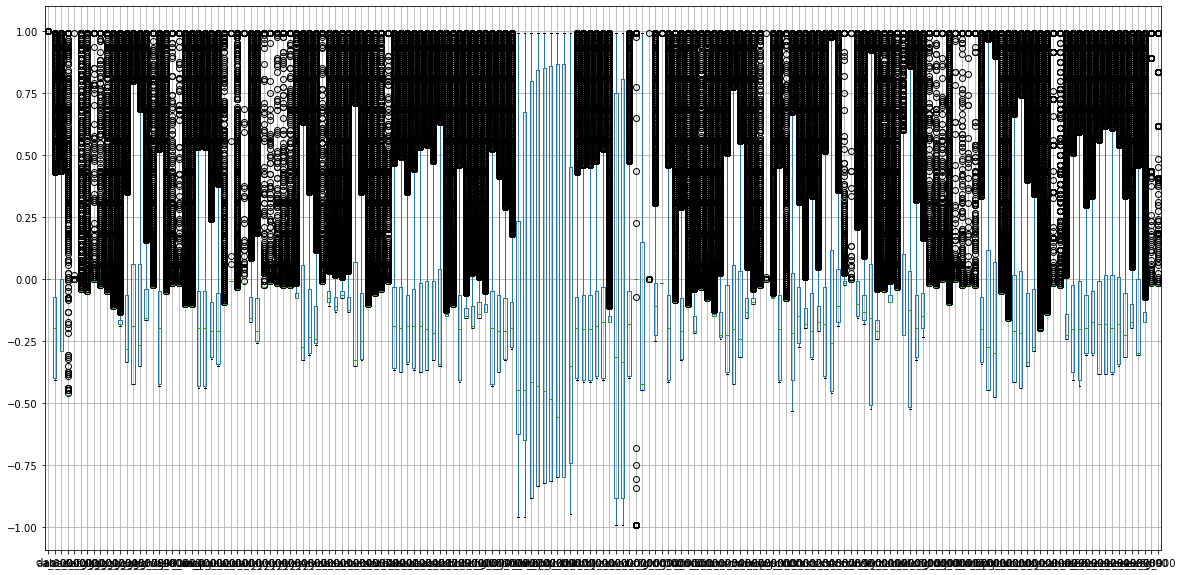

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
train.boxplot(ax=ax)
plt.show()

具体的に、一部のデータのパーセンタイル値をみると、２５，５０，７５の各パーセンタイルで同じ値を持つセンサーデータ値が多い傾向にあることが見て取れる。
極端に一部の値に集中していることがわかる。

これは、対象がセンサーによるものであることから、多くは故障状態以外の定常状態を計測しているとすれば、十分ありうる状況である。
機械の異常診断を行う際には、圧倒的多数の正常データから、少ない異常データを導くモデルを構築する必要があると考えられる。

In [7]:
train.describe()

class        aa_000        ab_000        ac_000        ad_000  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.016667     -0.124611     -0.071121     -0.198529     -0.007737   
std        0.128020      0.367680      0.356812      0.564872      0.004138   
min        0.000000     -0.406250     -0.289062     -0.468750     -0.007812   
25%        0.000000     -0.398438     -0.289062     -0.468750     -0.007812   
50%        0.000000     -0.195312     -0.289062     -0.468750     -0.007812   
75%        0.000000     -0.070312     -0.000000     -0.468750     -0.007812   
max        1.000000      0.992188      0.992188      0.992188      0.992188   

             ae_000        af_000        ag_000        ag_001        ag_002  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      -0.033483     -0.040633     -0.006584     -0.026241     -0.040699   
std        0.107086      0.111752      0.032016      0.065200      0.105864   
min       -0.046875     -0.054688     -0.007812     -0.031250     -0.054688   
25%       -0.046875     -0.054688     -0.007812     -0.031250     -0.054688   
50%       -0.046875     -0.054688     -0.007812     -0.031250     -0.054688   
75%       -0.046875     -0.054688     -0.007812     -0.031250     -0.054688   
max        0.992188      0.992188      0.992188      0.992188      0.992188   

       ...        ee_002        ee_003        ee_004        ee_005  \
count  ...  60000.000000  60000.000000  60000.000000  60000.000000   
mean   ...     -0.104808     -0.098734     -0.094976     -0.089227   
std    ...      0.356547      0.362066      0.363148      0.336121   
min    ...     -0.382812     -0.382812     -0.382812     -0.351562   
25%    ...     -0.382812     -0.382812     -0.375000     -0.343750   
50%    ...     -0.179688     -0.179688     -0.195312     -0.179688   
75%    ...     -0.007812      0.015625      0.015625      0.007812   
max    ...      0.992188      0.992188      0.992188      0.992188   

             ee_006        ee_007        ee_008        ee_009        ef_000  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      -0.103374     -0.088961     -0.084540     -0.067471     -0.020035   
std        0.320314      0.237613      0.363893      0.261009      0.051907   
min       -0.312500     -0.195312     -0.304688     -0.171875     -0.023438   
25%       -0.312500     -0.195312     -0.304688     -0.171875     -0.023438   
50%       -0.226562     -0.171875     -0.296875     -0.171875     -0.023438   
75%       -0.054688     -0.101562     -0.000000     -0.132812     -0.023438   
max        0.992188      0.992188      0.992188      0.992188      0.992188   

             eg_000  
count  60000.000000  
mean      -0.018417  
std        0.061751  
min       -0.023438  
25%       -0.023438  
50%       -0.023438  
75%       -0.023438  
max        0.992188  

[8 rows x 171 columns]

APSの異常を示すクラス1の実際の割合を見ると、訓練データは全部で60,000件あり、そのうちの1,000件（17%)である。
これは、171の多くのセンサーは、APSの異常発生時においても、定常状態と同じ値を異常時も示している可能性がある。
１７１の特徴量の中から、異常状態を判別するための組み合わせを人出で行うのは、非現実的であり、科学的なアプローチを通じて自動的に行う方法を提案する必要がある。

In [8]:
X = train.drop('class', axis=1)
y = train['class']

# use the given test set, instead of creating from the training samples
X_test_given = test.drop('class', axis=1)
y_test_given = test['class']

In [9]:
y.value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [10]:
1000/60000

0.016666666666666666

In [11]:
y_test_given.value_counts()

0    15625
1      375
Name: class, dtype: int64

In [12]:
375/(15625+375)

0.0234375

次に、今回採用したデータの特徴量間の相関について調査する。

センサーデータ間の相関係数をヒートマップとして図示した。
このヒートマップは正の相関が強いほど白に近い赤、弱いほど白に近い青で表示される。
相関の強さとヒートマップの色との関係については、図の左の棒に尺度が示されている。
ヒートマップ中に白に近い赤となっている特徴量の組み合わせが全体的に見られる。
このことから、強い正の相関を持つ特徴量の組み合わせが多く存在することがわかる。

対象データについては、特徴量の名称が匿名化されているので、具体的なセンサーの測定対象や方法については不明ではある。
そのため、センサー間の測定対象については、ここでは不明だ。
一般に、センサーを同じ機器に対して複数設置して取り付け位置によるセンサー情報の違いなどを検証する場合もある。
こうしたことから推論すると、同じような機器に発生したイベントのデータを取得することになり、相関が強く見られていることなどが考えられる。

本件は171と特徴量が比較的多いことから、相関の強い特徴量についてまとめて独立性の高い特徴量を新たに設定することで、モデル構築の際の計算コストを削減と、予測精度の向上を図る。

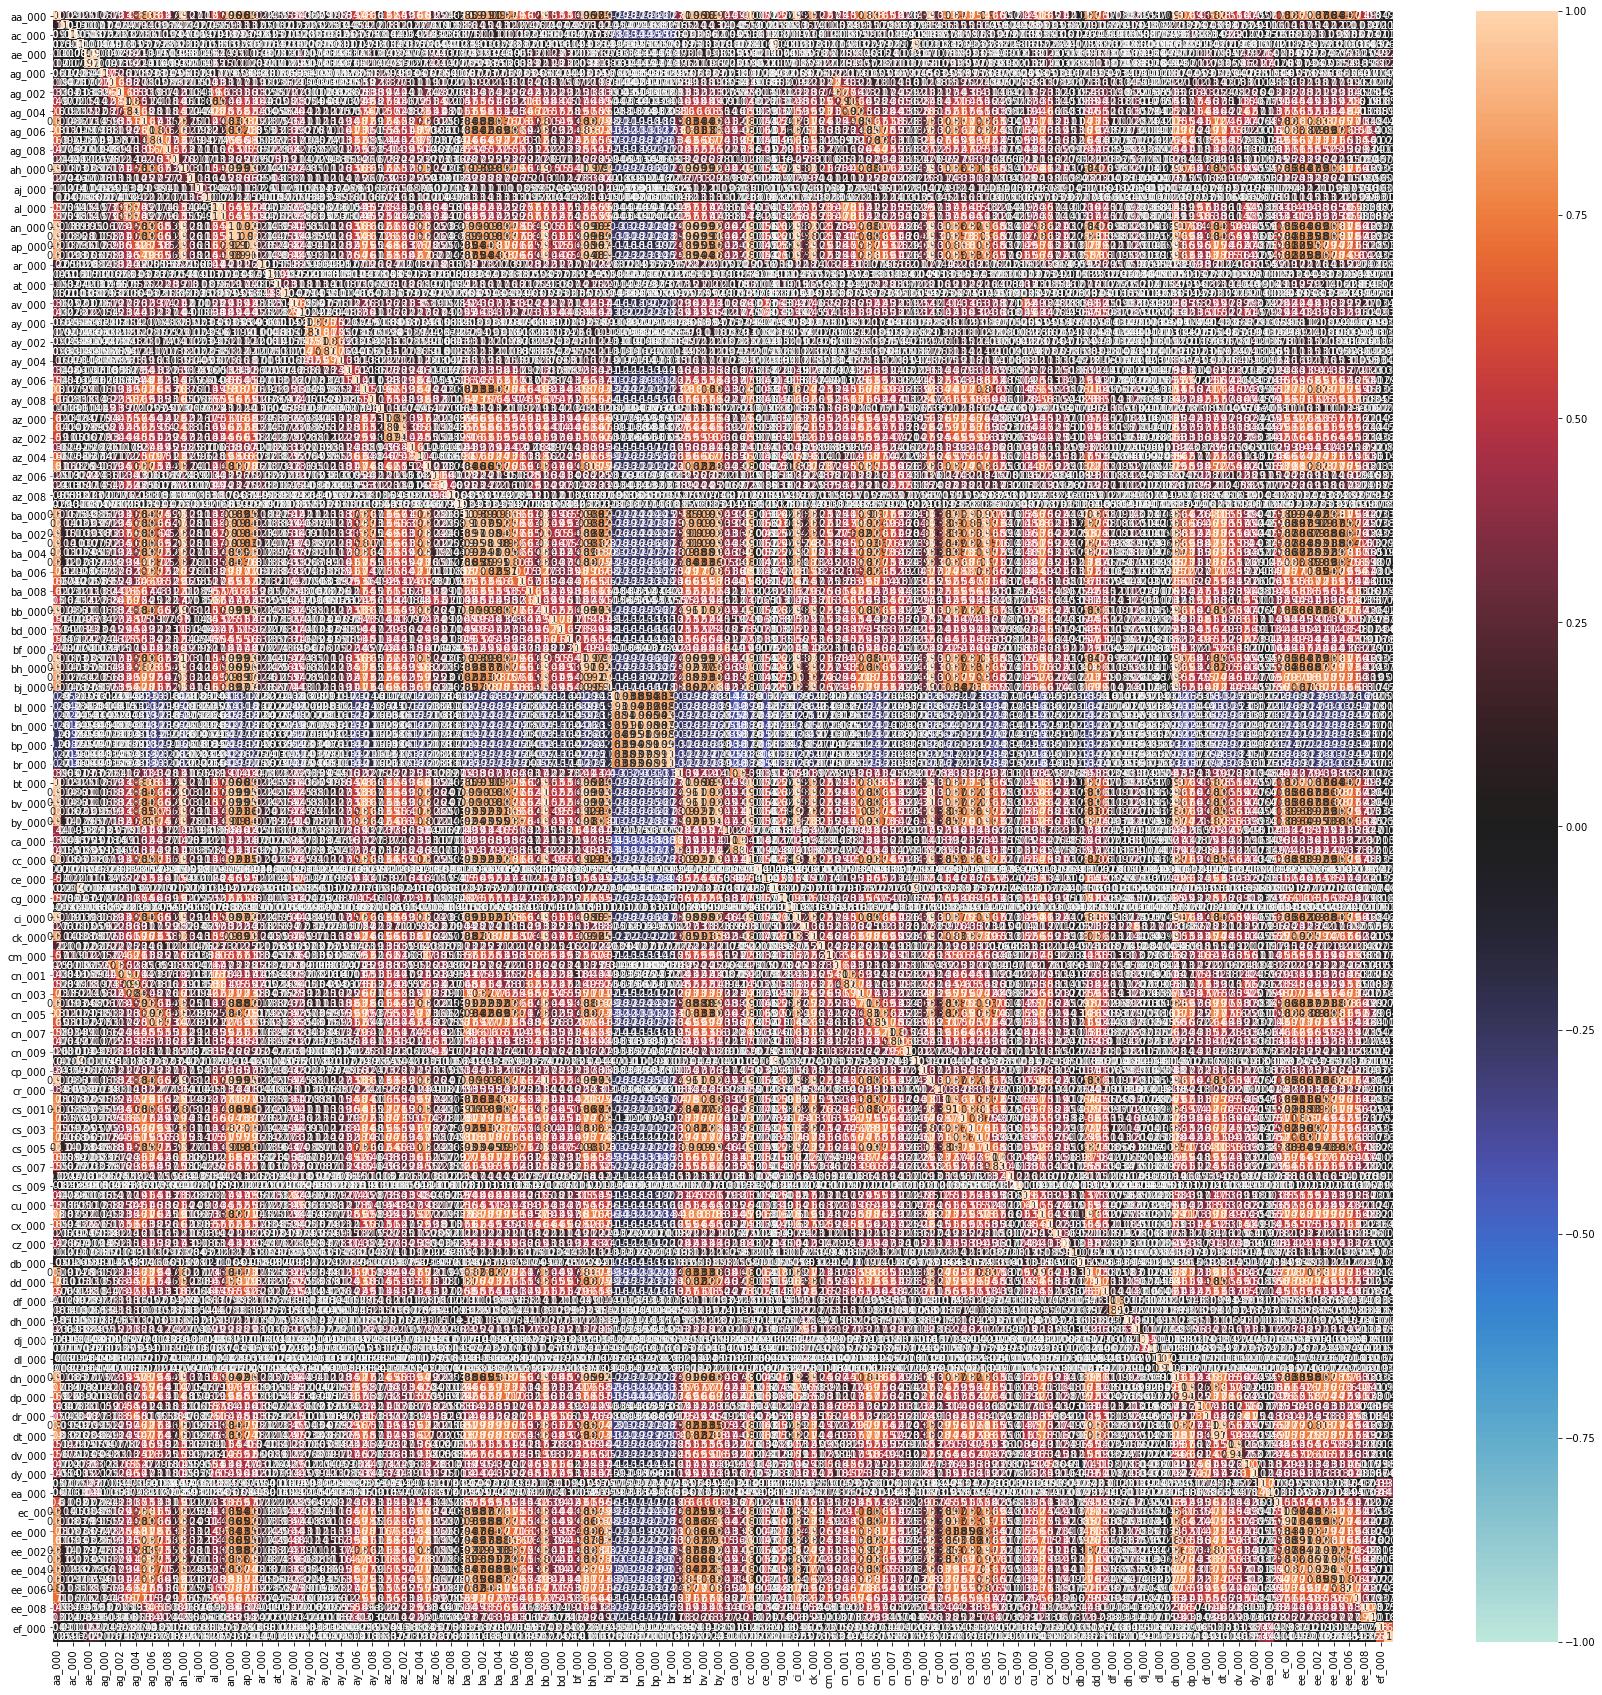

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(X.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

特徴量間で値の分布が極端に異なる場合に、計算機乗の丸めの影響により精度が影響を受ける場合がある。
そのため、スケール変換により、分布の幅による影響を回避することがある。
本レポートの対象データについては、上述のボックス図に見る通りもともと−1から1の範囲にスケール調整されていた。
そのため、スケール返還後も下記のボックス図に見る通り、分布の様子は変わらず、今回のデータについてはスケール変換の効果は少ないと判断した。
今回のモデル構築にあたってはスケール変換は行わない。

In [14]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

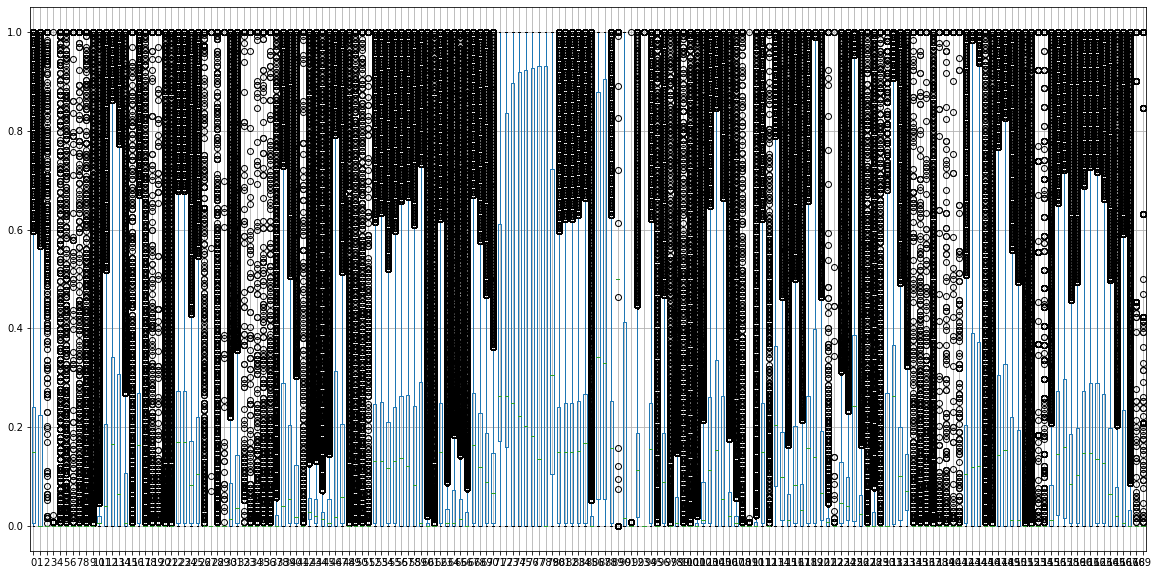

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_scaled).boxplot(ax=ax)
plt.show()

75パーセンタイルのデータは中央に集中しているものの、残りのデータについては幅広く広がっていることがわかる。 PCA適用後のデータであり、クラスタ化されているという前提のもと、クラスタの中心から遠いデータをOutlierとして除外する。
ここではOne Class SVMにより、Outlierの判定を行った。 https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

PCA変換するにあたり、98％の寄与率で特徴量を選んだ。この結果171の特徴量を67まで削減している。削減後の特徴量は互いに無相関となり、相互相関係数はほぼ0となっていることが見て取れる。

PCA変換後の特徴量に対し、ボックス図を描くと0付近に多くのデータが集約し、75パーセンタイルに含まれないデータの裾野が長いことが見て取れる。
所与のトレーニングデータは均一なデータが多く、そこから外れるデータに多様性があることがわかる。

In [16]:
pca = PCA(0.98)
pca.fit(X)
pca.n_components_
X_reduced_data = pca.transform(X)
X_reduced_data.shape

(60000, 67)

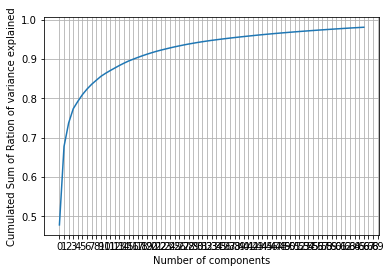

In [17]:
plt.xlabel("Number of components")
plt.ylabel("Cumulated Sum of Ration of variance explained")
plt.xticks(range(0,87))
plt.grid(True)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

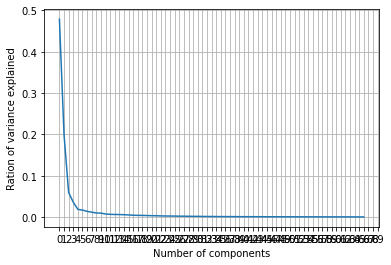

In [18]:
plt.xlabel("Number of components")
plt.ylabel("Ration of variance explained")
plt.xticks(range(0,87))
plt.grid(True)
plt.plot(pca.explained_variance_ratio_)
plt.show()

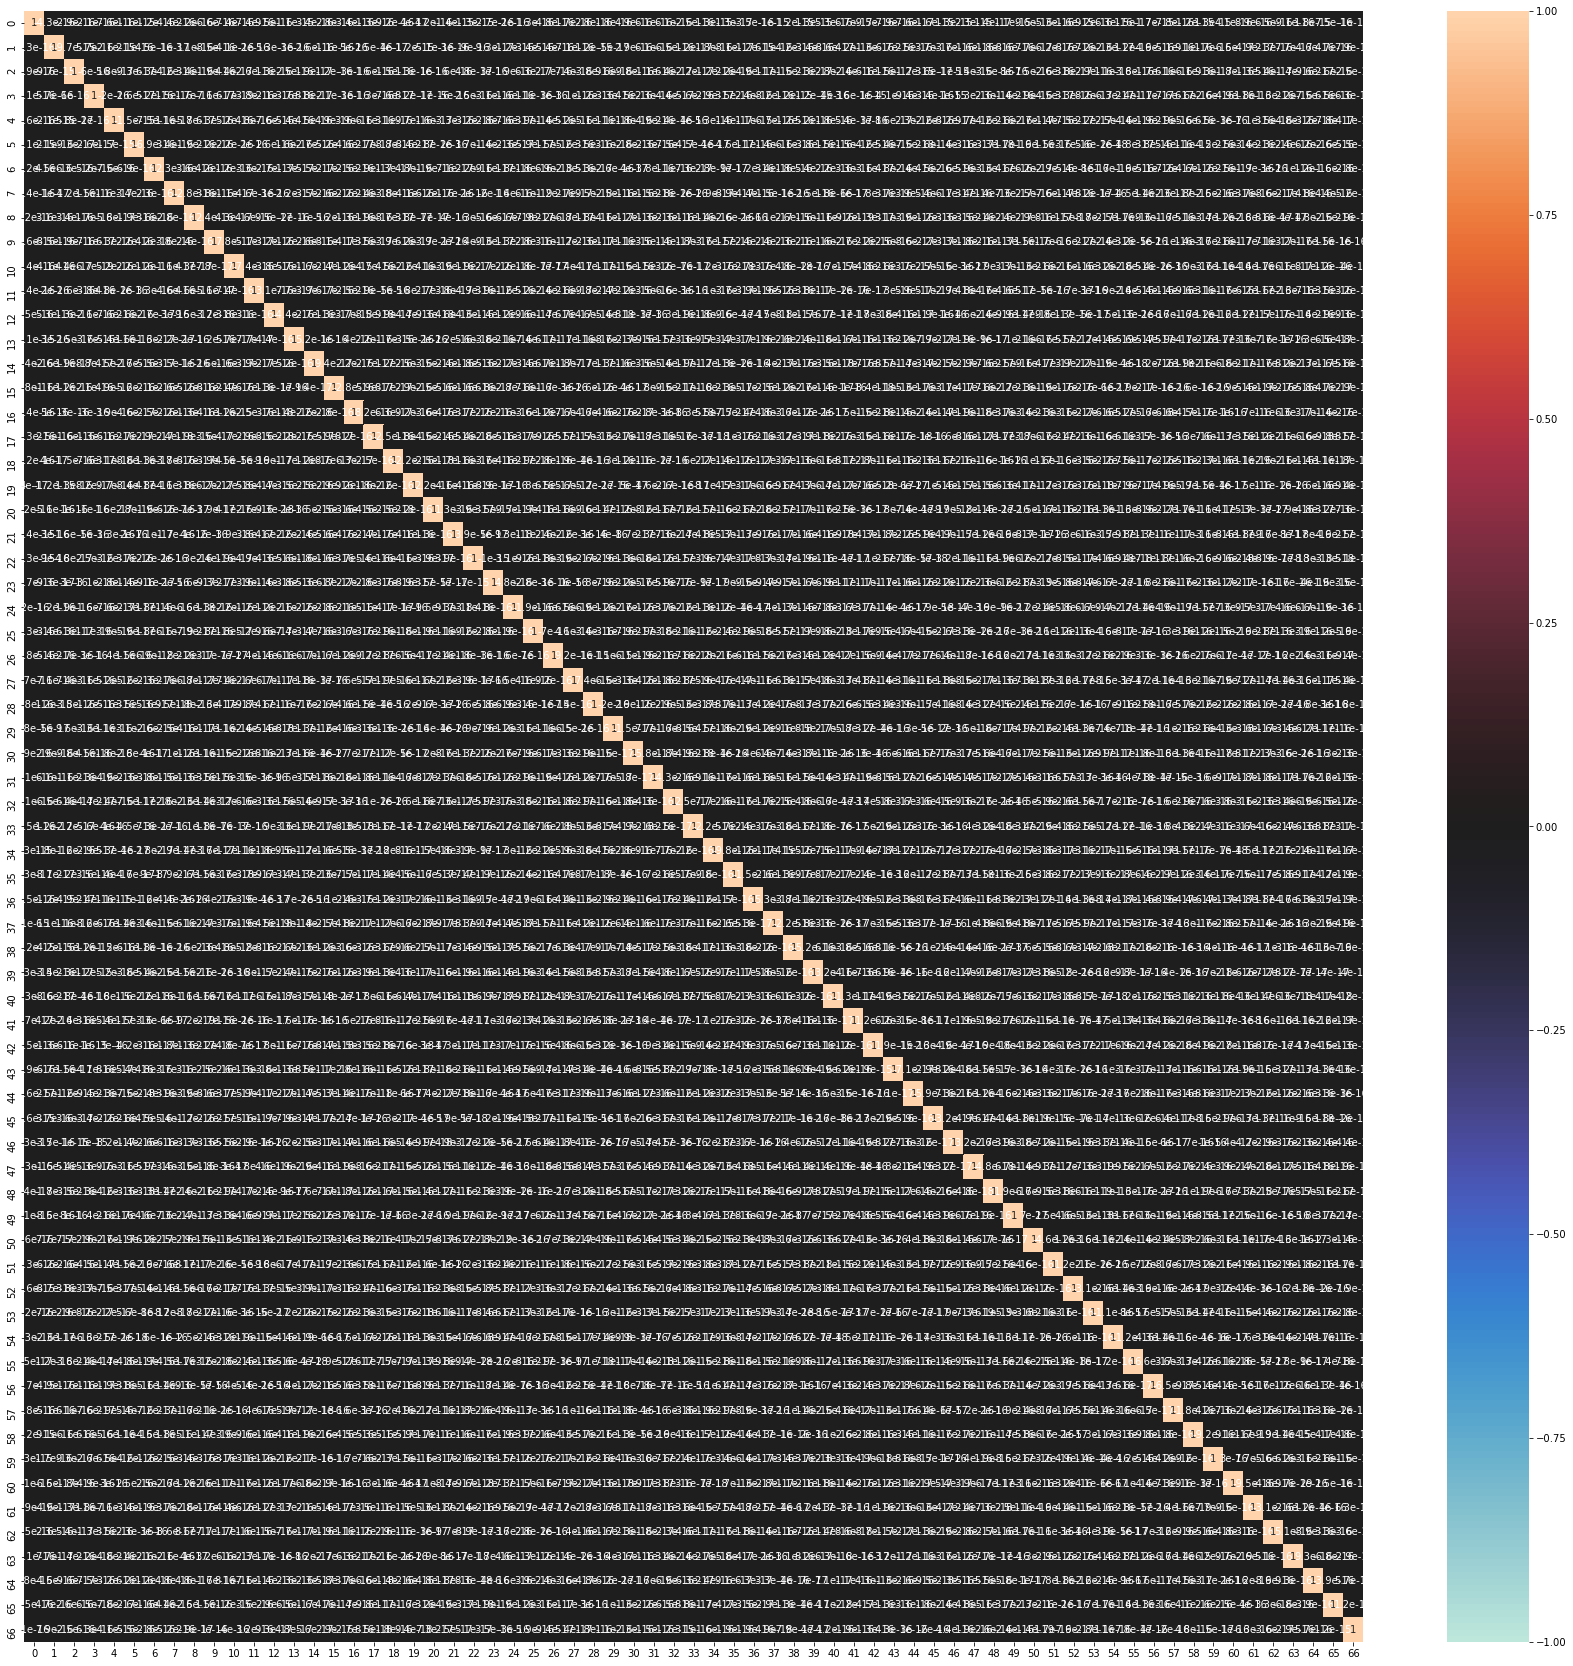

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(pd.DataFrame(X_reduced_data).corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

PCA(Primary Component Classifier)により171個の特徴量を削減し、互いに相関の低い67個の特徴量に変換することができたが、モデル構築時の計算コストや、精度の向上が期待できるものの、分類が適切に行えているか検証する。
ポジティブクラス( consists of component failures for a specific component of the APS system)を分類するモデルの精度を高めることが本プロジェクトの目的である。
これらのデータがPCAによる変換後にどのように分類されているか確認した。

One Class SVMによって50％を区切りにPositive ClassとNegative Classの割合をそれぞれ求めた
60000件のデータを2つに分けると、One Class SVMによって除外されるOutに分類されたデータにほとんどのPositiveクラスが分類されている。
One Class SVMによる分類では、検出対象のPositiveクラスがほとんど除外されてしまうことがわかる。

|-| Positive | Negative |
|-|-|-|
|Out | 991 | 29009 |
|In | 9 | 2991 |

センサーデータについては、ほとんどのデータは正常状態のデータである。
今回のNegativeクラスのデータについては、何らかの車載コンポーネントに異常時に取得したデータではあるものの、対象となるAPSの異常が発生していない状況で取得されたデータだ。
そのため、正常状態に偏ったデータが取得されていると考えられる。

上記のことから、Outlierに重要なデータが含まれていると考え、Outlierの棄却は行わない。

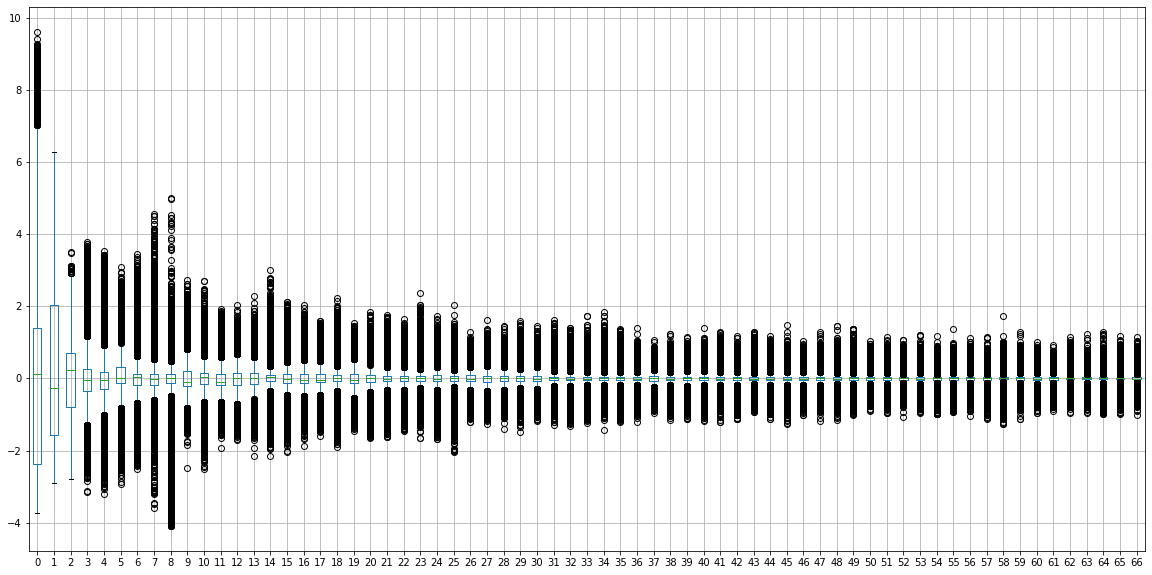

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_reduced_data).boxplot(ax=ax)
plt.show()

In [21]:
%time
# fit the model
ocsvm = OneClassSVM(nu=0.5, kernel='rbf', gamma='auto')
ocsvm.fit(X_reduced_data)

y_pred = ocsvm.predict(X_reduced_data)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


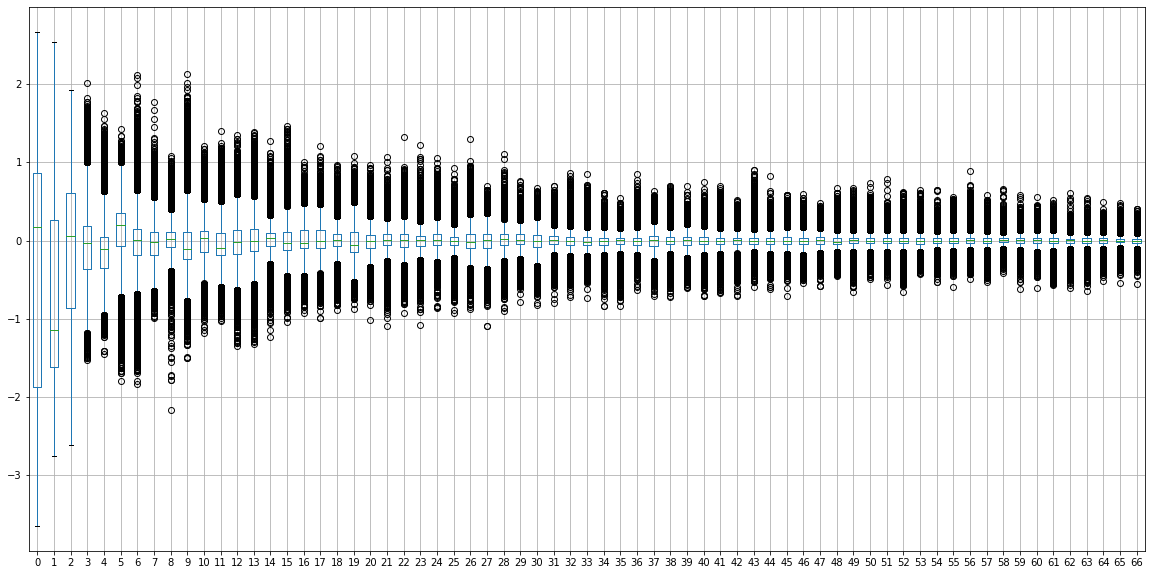

In [22]:
OUTLIER_DATA = -1
predicted_normal_index = np.where(y_pred != OUTLIER_DATA)
X_normal = X_reduced_data[predicted_normal_index]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_normal).boxplot(ax=ax)
plt.show()

In [23]:
predicted_normal_index = np.where(y_pred != OUTLIER_DATA)
y_normal = y[predicted_normal_index[0]]
y_normal.value_counts()

0    29991
1        9
Name: class, dtype: int64

Positiveデータがほとんど除外されてしまったことがわかる

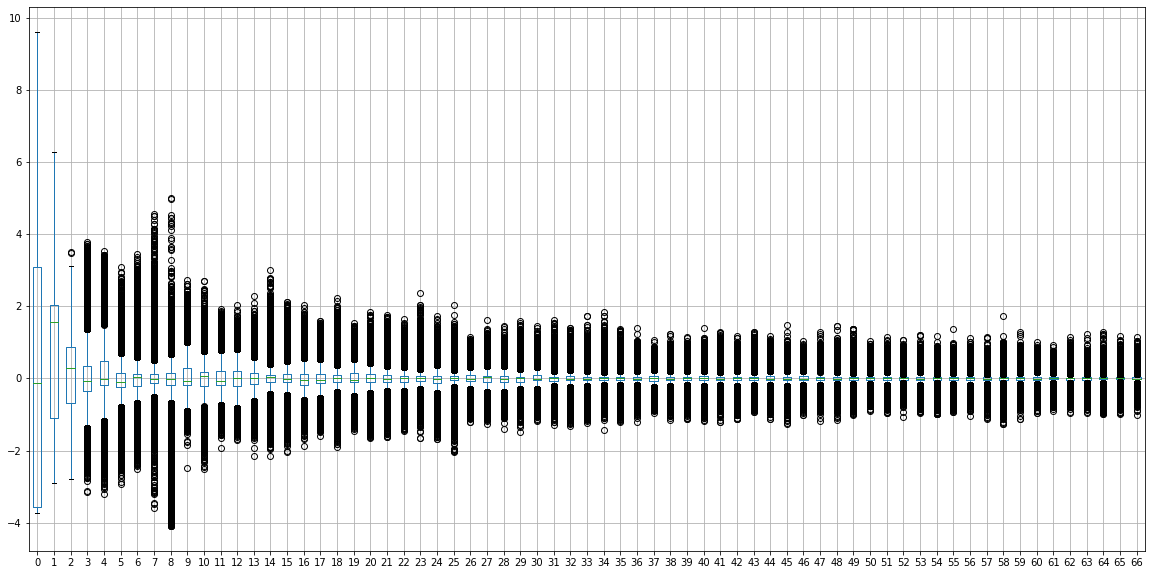

In [24]:
OUTLIER_DATA = -1
predicted_anormaly_index = np.where(y_pred == OUTLIER_DATA)
X_anomaly = X_reduced_data[predicted_anormaly_index]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_anomaly).boxplot(ax=ax)
plt.show()

In [25]:
predicted_anormaly_index = np.where(y_pred == OUTLIER_DATA)
y_anomaly  = y[predicted_anormaly_index[0]]
y_anomaly.value_counts()

0    29009
1      991
Name: class, dtype: int64


outlierは棄却せず、裾のの広がりを緩和するために、対数変換してみる

In [26]:
X_reduced_test_data = pca.transform(X_test_given)

MIN = min(np.min(X_reduced_data), np.min(X_reduced_test_data)) - 0.1
MIN

-4.226051165195022

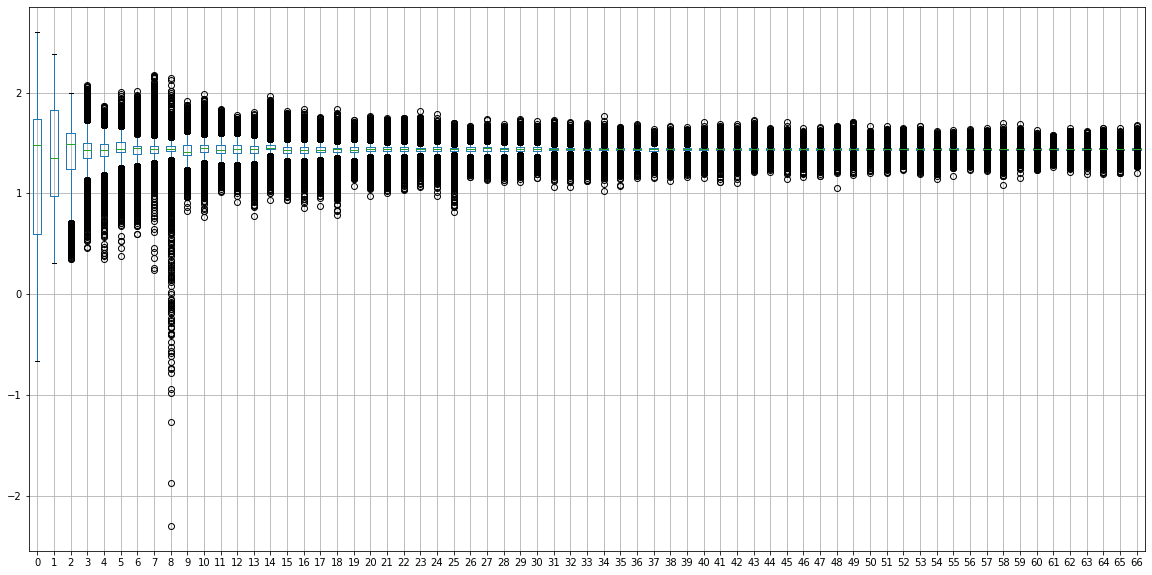

In [27]:
X_reduced_test_data_log = np.log(X_reduced_test_data - MIN)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.DataFrame(X_reduced_test_data_log).boxplot(ax=ax)
plt.show()

### Evaluation Metrics

In evaluating the prediction logic, it is a challenge to extract failure events as much as possible while maintaining the operation rate. For that reason, it is necessary to accurately derive the judgment of correctness. Here, to make the balance of Confusion Matrix, adopt a model with a high result of scoring by ROC-AUC.


Accuracy, Precision, Recallのそれぞれを評価する。

### Benchmark Model

As benchmark, adopts 60% correct answer rate.
This is based on a hearing from an interview myself conducted that the failure rate prevented by regular maintenance is about 60% by experience.
It is worth considering the devided model in this project, if failure prediction is more than 60% Accuracy.

ただ、モデルの精度は極力高められることが望ましい。
採用するべきデータ前処理ならびにXGBoostモデルのハイパーパラメータのベンチマークとして、RandomForestモデルと比較して評価する。

Random Forest uses a set of decision trees, and each tree represents some decision path to 'income' class, from features. Subset of features like 'capital-gain', 'education-num', 'age' and etc are used in each tree. The features picked up are different amond trees. These features are used in the list of questions as a branch in the tree to reach from the ground to leaves(=income).

Usually, a single tree is not strong enough to be used in practice. To overcome this, Random Forest uses a lot of decision trees which are slightly differentn with each other. When we get a new answer from those trees, we take the majority vote of among the trees to get a final result. Compared to employing a single tree, you can reduce the proportion of incorrect results. By default, a Random Forest will use the sqaure root of the number of features as the maximum features that it will look on any given branch. In our case we have total 103 features, so each decision will be the best of the 10(approximate) randomly selected features available.

In [28]:
X_train = X
X_test = X_test_given

y_train = y
y_test = y_test_given

In [29]:
logistic = LogisticRegression(random_state=42, solver='lbfgs',  multi_class='multinomial').fit(X, y)
predictLogistic = logistic.predict(X_test_given)
score = logistic.predict_proba(X)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y, score[:, 1], average='macro')))
print("accuracy score : {}".format(accuracy_score( y_test_given, predictLogistic)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predictLogistic)))
print(classification_report( y_true = y_test_given, y_pred = predictLogistic ))
print(confusion_matrix(y_true = y_test_given, y_pred = predictLogistic))

Best ROC-AUC: 0.9890
accuracy score : 0.9896875
R-squared, coefficient of determination : 0.549
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.85      0.69      0.76       375

    accuracy                           0.99     16000
   macro avg       0.92      0.84      0.88     16000
weighted avg       0.99      0.99      0.99     16000

[[15578    47]
 [  118   257]]


/home/hajime/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Random Forest Classifier


In [30]:
rfPredictor = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42).fit(X,y)
predictRF = rfPredictor.predict(X_test_given)
score = rfPredictor.predict_proba(X)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y, score[:, 1], average='macro')))
print("accuracy score : {}".format(accuracy_score( y_test_given, predictRF)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predictRF)))
print(classification_report( y_true = y_test_given, y_pred = predictRF))
print(confusion_matrix(y_true = y_test_given, y_pred = predictRF))

Best ROC-AUC: 0.9885
accuracy score : 0.9858125
R-squared, coefficient of determination : 0.380
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.97      0.41      0.57       375

    accuracy                           0.99     16000
   macro avg       0.98      0.70      0.78     16000
weighted avg       0.99      0.99      0.98     16000

[[15621     4]
 [  223   152]]


In [99]:
from sklearn2pmml.pipeline import PMMLPipeline

from sklearn2pmml import sklearn2pmml

pipeline_model = PMMLPipeline([('rf_classifier', rfPredictor)]).fit(X,y)
sklearn2pmml(pipeline_model, './model/rfc.pmml', with_repr = True)

/home/hajime/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


#### XGBClassifier

In [33]:
%%time
predictor = xgb.XGBClassifier(seed=42,
                             tree_method='hist')

predictor.fit(X_train, y_train)

CPU times: user 16.7 s, sys: 164 ms, total: 16.9 s
Wall time: 1.59 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [34]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.9923125
R-squared, coefficient of determination : 0.664
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.93      0.73      0.82       375

    accuracy                           0.99     16000
   macro avg       0.96      0.86      0.91     16000
weighted avg       0.99      0.99      0.99     16000



array([[15604,    21],
       [  102,   273]])

#### XGBClassifier

In [35]:
%%time
predictor = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=5,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5, tree_method='hist', verbose=10)

predictor.fit(X_train, y_train)

[16:23:30] WARNING: xgboost/src/learner.cc:485: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 31.7 s, sys: 132 ms, total: 31.8 s
Wall time: 8.08 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=5, max_depth=5,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=0.5, tree_method='hist',
              validate_parameters=1, verbose=10, verbosity=None)

In [36]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.9925
R-squared, coefficient of determination : 0.672
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.91      0.76      0.83       375

    accuracy                           0.99     16000
   macro avg       0.95      0.88      0.91     16000
weighted avg       0.99      0.99      0.99     16000



array([[15596,    29],
       [   91,   284]])

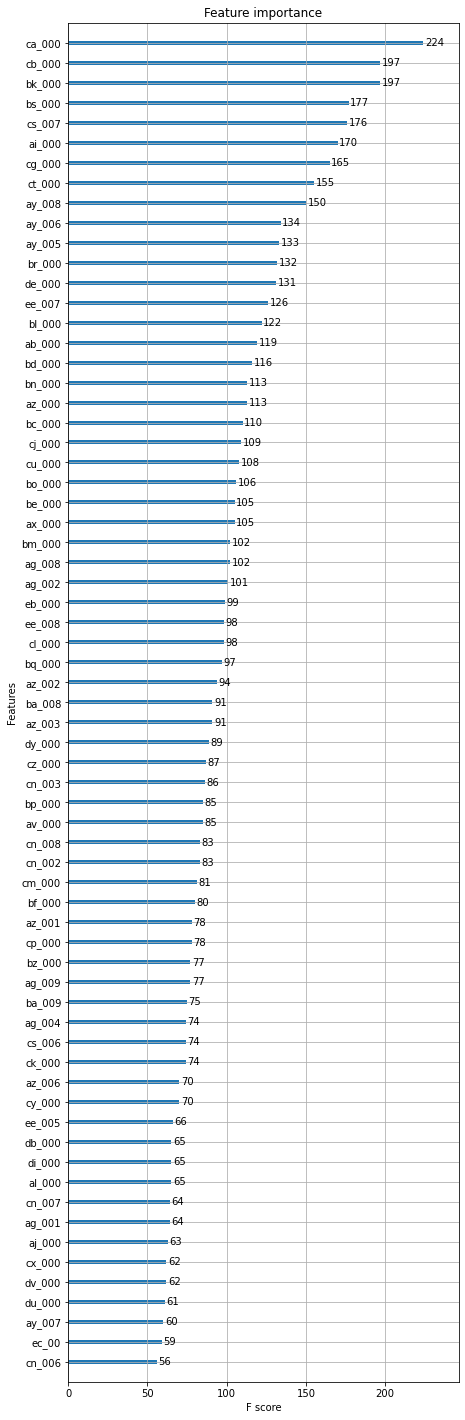

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

#### PCAにより次元削減したデータセットに対するXGBoost


In [39]:
X_train = X_reduced_data
X_test = X_reduced_test_data

y_train = y
y_test = y_test_given

In [40]:
%%time
predictor = xgb.XGBClassifier(seed=42,tree_method='hist')

predictor.fit(X_train, y_train)

CPU times: user 3.97 s, sys: 31.9 ms, total: 4.01 s
Wall time: 1.06 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [41]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.9884375
R-squared, coefficient of determination : 0.495
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.88      0.58      0.70       375

    accuracy                           0.99     16000
   macro avg       0.94      0.79      0.85     16000
weighted avg       0.99      0.99      0.99     16000



array([[15596,    29],
       [  156,   219]])

In [42]:
%%time
predictor = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=5,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5, tree_method='hist', verbose=10)

predictor.fit(X_train, y_train)

[16:25:19] WARNING: xgboost/src/learner.cc:485: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 19.6 s, sys: 59.8 ms, total: 19.6 s
Wall time: 4.98 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=5, max_depth=5,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=0.5, tree_method='hist',
              validate_parameters=1, verbose=10, verbosity=None)

In [43]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.9895
R-squared, coefficient of determination : 0.541
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.89      0.63      0.74       375

    accuracy                           0.99     16000
   macro avg       0.94      0.81      0.87     16000
weighted avg       0.99      0.99      0.99     16000



array([[15597,    28],
       [  140,   235]])

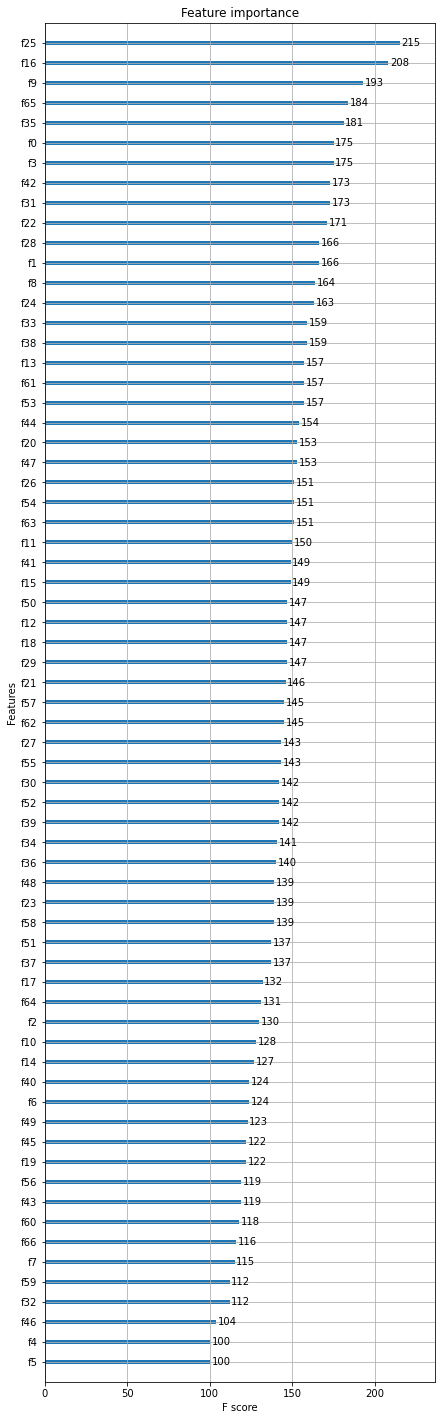

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

#### Log TransformによりSkeｗならびに裾野のデータを調整したXGBoost

In [46]:
MIN = min(np.min(X_reduced_data), np.min(X_reduced_test_data)) - 0.1

X_train = np.log(X_reduced_data - MIN)
X_test = np.log(X_reduced_test_data - MIN)

y_train = y
y_test = y_test_given

In [47]:
%%time
predictor = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=5,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5, tree_method='hist', verbose=10)

predictor.fit(X_train, y_train)

[16:26:19] WARNING: xgboost/src/learner.cc:485: 
Parameters: { silent, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 20.1 s, sys: 91.9 ms, total: 20.1 s
Wall time: 5.13 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=5, max_depth=5,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=0.5, tree_method='hist',
              validate_parameters=1, verbose=10, verbosity=None)

In [48]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test_given, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.9895625
R-squared, coefficient of determination : 0.544
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.89      0.63      0.74       375

    accuracy                           0.99     16000
   macro avg       0.94      0.82      0.87     16000
weighted avg       0.99      0.99      0.99     16000



array([[15596,    29],
       [  138,   237]])

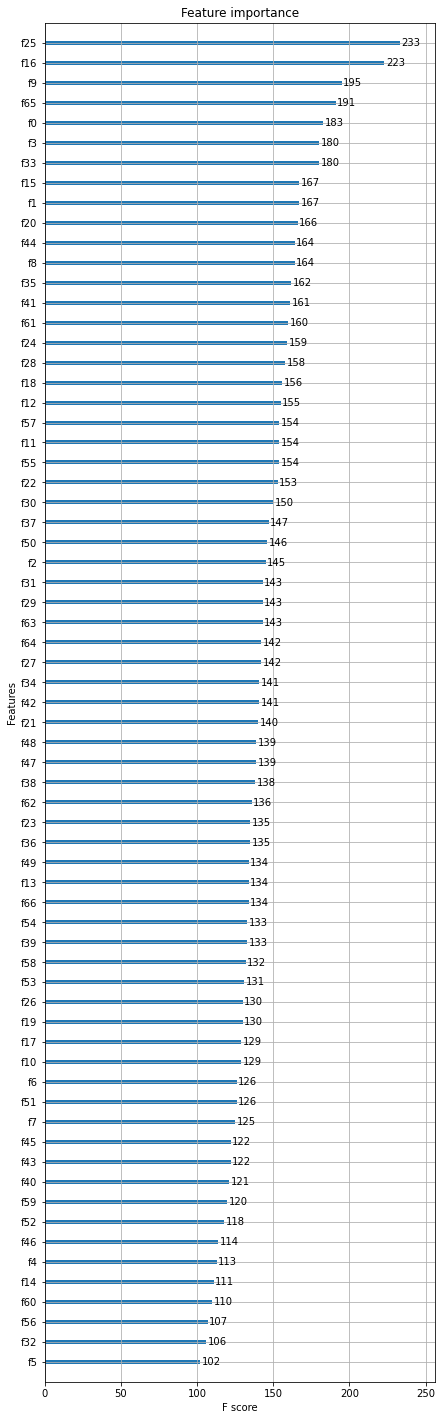

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

#### 評価

Implementation: Define a Performance Metric

It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the coefficient of determination, R2, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions.

The values for R2 range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable. A model with an R2 of 0 is no better than a model that always predicts the mean of the target variable, whereas a model with an R2 of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features. A model can be given a negative R2 as well, which indicates that the model is arbitrarily worse than one that always predicts the mean of the target variable.

For the performance_metric function in the code cell below, you will need to implement the following:

    Use r2_score from sklearn.metrics to perform a performance calculation between y_true and y_predict.
    Assign the performance score to the score variable.


    R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
    R2 score of 1 means the dependent variable can be predicted from the independent variable.
    R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An
    R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

文献Tarald O. Kvalseth: "Cautionary Note about R2", The American Statistician Vol. 39, No. 4, Part 1 (Nov., 1985), pp. 279-285
の（１）の定義を採用する。

R-squared, coefficient of determination
$$ 
1 - \frac{\sum_{n-1}^{i=0} (y_i - \hat{y})^2}{\sum_{n-1}^{i=0} (y_i -\overline{y})^2}
$$ 

$$ 
y : Actual Value
\hat{y} : Predicted Value
\overline{y} : Average Value
n : the number of samples
$$ 

ROC-AUC and accuracy score are close to 1.0 for any models benchmarked.
But R-squred, coefficient of determination is best 0.675 only for XGBoost.

XGBoost improved the predictio model against Rando Forest in this case.
But R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.
Which is lower than the regular maintenance measure.


RainForestよりも良い結果が得られているが、データの前処理を行わないほうが、R2スコアが良い傾向にあることがわかる。
また、ハイパーパラメータを調整することでさらにR2スコアが改善されることが予測される。
今回の対象データは、検出したい対象クラスが分布の中心の75パーセンタイルから外れる少数派に含まれるという、データ分布上の特徴があった。
完全にランダムなデータではなく、測定対象固有の確率分布に従っている可能性がある。
そのため、正規分布を想定したデータの前処理はモデルの精度を高めることにはつながらず、むしろ分布の少数派のデータは積極的に活用したほうがよいことが推測される。

これらのことから、当初の60％以上の正確さを期して、データ前処理を行わずに、XGBoostで最適なハイパーパラメータを調整することにする。

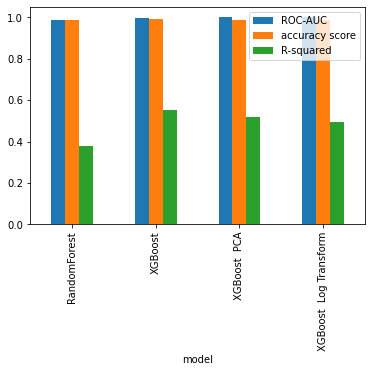

In [51]:
df_eval = pd.DataFrame([{"model":"RandomForest", "ROC-AUC": 0.9885, "accuracy score" : 0.9858125, "R-squared" : 0.380},
{"model":"XGBoost", "ROC-AUC": 0.9944, "accuracy score" : 0.98975, "R-squared" : 0.552},
{"model":"XGBoost  PCA", "ROC-AUC": 1.0000, "accuracy score" : 0.9889375, "R-squared" : 0.517},
{"model":"XGBoost  Log Transform", "ROC-AUC": 1.0000, "accuracy score" : 0.9884375, "R-squared" : 0.495}]).set_index('model', drop=True)
df_eval.plot(kind="bar")

Precision,Recallなどみてもデータ前処理を行わないXGBoostが高い性能を発揮していることがわかる。

##### RandomForest
              precision    recall  f1-score   support
           0       0.99      1.00      0.99     15625
           1       0.97      0.41      0.57       375

 
##### XGBoost 

              precision    recall  f1-score   support
           0       0.99      1.00      1.00     15625
           1       0.92      0.75      0.83       375


##### XGBoost  PCA

              precision    recall  f1-score   support
           0       0.99      1.00      0.99     15625
           1       0.89      0.60      0.72       375


##### XGBoost  Log Transform

              precision    recall  f1-score   support
           0       0.99      1.00      0.99     15625
           1       0.89      0.58      0.70       375


## Seek hyperparameters

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

訓練データとテストデータについては、上記を踏まえて前処理を施さない、所与のデータを活用する。

In [52]:
X_train = X
X_test = X_test_given

y_train = y
y_test = y_test_given

ハイパーパラメータの決定にあたり、本プロジェクトは以下の探索を行った。
事前に、いくつかのパラメータを調整し、改善効果の大きかった*max_depth (int)*, *n_estimators (int)*に対象を絞っている。

| Parameter | Description | Search Rangge |
|-|-|-|
| max_depth (int) | Maximum tree depth for base learners. | [5,6,7] |
| learning_rate (float) | Boosting learning rate (xgb’s “eta”) | 0.1(Fixed) |
| n_estimators (int) | Number of boosted trees to fit.| [300, 500, 700] |
| objective (string or callable) | Specify the learning task and the corresponding learning objective or a custom objective function to be used. | ['binary:logistic'] |
| booster (string) | Specify which booster to use | gbtree |
| gamma (float) | Minimum loss reduction required to make a further partition on a leaf node of the tree. | [0.0] (Fixed) |
|min_child_weight (int) |  Minimum sum of instance weight(hessian) needed in a child. | [1]|
|max_delta_step (int) | Maximum delta step we allow each tree’s weight estimation to be.| [5] |
| subsample (float) | Subsample ratio of the training instance. | [0.5] (Fixed) |
| colsample_bytree (float) | Subsample ratio of columns when constructing each tree. | [0.8] |

In [93]:
%%time

params = {
'max_depth':[5,6,7],
'learning_rate':[0.1],
'gamma':[0.0],
'min_child_weight':[1],
'max_delta_step':[5],
'colsample_bytree':[0.8],
'n_estimators':[300, 500, 700],
'subsample':[0.5],
'objective':['binary:logistic'],
'nthread':[4],
'scale_pos_weight':[1],
'seed':[random_seed],
'verbose': [10],
'tree_method':['exact']}


model = xgb.XGBClassifier(tree_method='hist')
#cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')
cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='recall')
RandomForestClassifier 
cv.fit(X_train, y_train)
print(cv.best_estimator_)

[10:28:38] WARNING: xgboost/src/learner.cc:485: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=5, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbose=10, verbosity=None)
CPU times: user 5min 50s, sys: 439 ms, to

In [94]:
predictor = cv.best_estimator_
predictor.save_model('./model/xgb.model')

In [95]:
import sklearn2pmml
from sklearn.preprocessing import LabelEncoder

pmml_model = sklearn2pmml.make_pmml_pipeline(predictor)
#pmml_model._le = xgb.compat.XGBoostLabelEncoder()
pmml_model._le = LabelEncoder()
pmml_model._le.fit(y_train)
pmml_model

/home/hajime/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PMMLPipeline(steps=[('estimator', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=5, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbose=10, verbosity=None))])

In [96]:
sklearn2pmml.sklearn2pmml(pmml_model, './model/xgb.pmml')

In [56]:
score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))
predict = predictor.predict(X_test)
print("accuracy score : {}".format(accuracy_score( y_test, predict)))
print("R-squared, coefficient of determination : {:.3f}".format(r2_score(y_test, predict)))
print(classification_report( y_true = y_test, y_pred = predict ))
confusion_matrix(y_true = y_test, y_pred = predict )

Best ROC-AUC: 1.0000
accuracy score : 0.992625
R-squared, coefficient of determination : 0.678
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.94      0.74      0.82       375

    accuracy                           0.99     16000
   macro avg       0.96      0.87      0.91     16000
weighted avg       0.99      0.99      0.99     16000



array([[15606,    19],
       [   99,   276]])

In [57]:
print("Best parameters: %s" % cv.best_params_)
print("Best auroc score: %s" % cv.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.5, 'tree_method': 'exact', 'verbose': 10}
Best auroc score: 0.7150000000000001


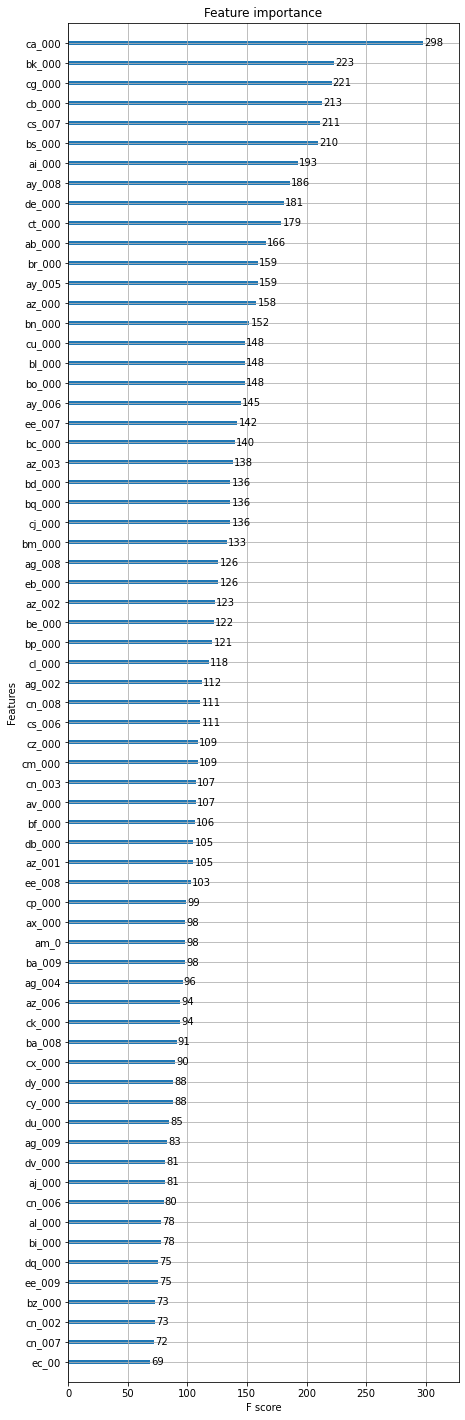

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
plot_importance(predictor, max_num_features = pca.n_components_, ax=ax)
plt.show()

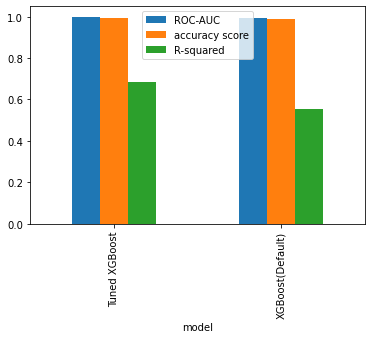

In [59]:
df_eval = pd.DataFrame([{"model":"Tuned XGBoost", "ROC-AUC": 1.0000, "accuracy score" : 0.99275, "R-squared" : 0.683},
                        {"model":"XGBoost(Default)", "ROC-AUC": 0.9944, "accuracy score" : 0.98975, "R-squared" : 0.552}]).set_index('model', drop=True)
df_eval.plot(kind="bar")

In [60]:
predictor = xgb.XGBClassifier()
booster = xgb.Booster()
booster.load_model('./model/xgb.model')
predictor._Booster = booster
predictor

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

## V. Conclusion

XGBoostを採用することで、ベンチマークに用いたRandom Forestよりも高い適合度の分類予測モデルを構築することができた。
ハイパーパラメータをチューニングすることで、モデルの適合度を上げることができた。

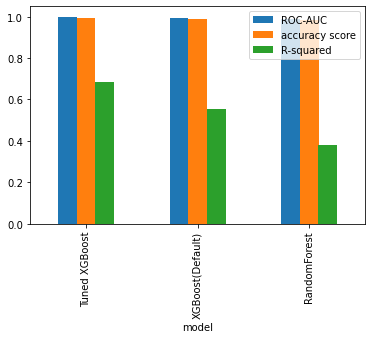

In [61]:
df_eval = pd.DataFrame([{"model":"Tuned XGBoost", "ROC-AUC": 1.0000, "accuracy score" : 0.99275, "R-squared" : 0.683},
                        {"model":"XGBoost(Default)", "ROC-AUC": 0.9944, "accuracy score" : 0.98975, "R-squared" : 0.552},
                        {"model":"RandomForest", "ROC-AUC": 0.9885, "accuracy score" : 0.9858125, "R-squared" : 0.380}]).set_index('model', drop=True)
df_eval.plot(kind="bar")

### Reflection

今回は、APSまわりのセンサーから取得したデータを元に、以上発生の有無を予測するモデルを作成した。
センサーデータの特徴として、大多数のデータは平常時のデータであり、多くの前処理で外れ値に分類されるような分布の中心から離れたデータも予測モデルの構築に重要な役割をはたすことが見てとれた。
また、そのため、特徴量間で強い相関が見られるものの、PCA等によりクラスタ化して、特徴を表す軸を見出し、特徴量を減らすといった処理をするよりも、そのままの特徴データを活用するほうがよい予測モデルを構築することができた。

このことは、クラス分けに寄与する決定木が導かれたら、PCAで必要となる特徴量の変換と逆変換といったステップを経ずに、重要な特徴量、すなわちセンサーを導けるといった点で利便性が高い。
トラックなどは、センサーが高価であり、設置に多くの労力とコスト、時間を要することから、XGBoostを活用した今回のアプローチは、車載センサーによる故障予測の分野で汎用的に役立つことが期待される。

このプロジェクトでは最後に、XGBoostのハイパーパラメータの調整を行った。調整を行うことでモデルの適合度を高めることができた。
ただし、全パラメータにわたって、調整を行うことは計算資源の制約から今回は見送った。

### Improvement

今回のデータ・セットはあらじめ検出対象のクラスの割合が調整されていた可能性がある。
通常のセンサーデータは、平常時のデータが圧倒的に多く生成される。
そのため異常時のデータがより少ない、調整前のデータに対しても今回のアプローチが有効であるか追加で検証することが、汎用的に実用化するには必要だと考えられる。
また、XGBoostはハイパーパラメータの調整に時間がかかるアプローチであり、そのためにGPUの活用など、計算機資源の強化による速度向上が期待できる。

### Output to PMML